In [3]:
!pip install pulp

   ---------------------------------------- 0.0/17.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.7 MB 162.5 kB/s eta 0:01:49
   ---------------------------------------- 0.0/17.7 MB 186.2 kB/s eta 0:01:35
   ---------------------------------------- 0.0/17.7 MB 217.9 kB/s eta 0:01:21
   ---------------------------------------- 0.1/17.7 MB 252.2 kB/s eta 0:01:10
   ---------------------------------------- 0.1/17.7 MB 423.5 kB/s eta 0:00:42
   ---------------------------------------- 0.2/17.7 MB 588.9 kB/s eta 0:00:30
   ---------------------------------------- 0.2/17.7 MB 565.6 kB/s eta 0:00:31
   ---------------------------------------- 0.2/17.7 MB 565.6 kB/s eta 0:00:31
   ---------------------------------------- 0.2/17.7 MB 565.6 kB/s eta 0:00:31
    --------------------------------------- 0.3/17.7 MB 491.5 kB/s eta 0:00:36


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import matplotlib.pyplot as plt

In [11]:
# Load the data
medal_counts = pd.read_csv("summerOly_medal_counts.csv", encoding="ISO-8859-1")
hosts = pd.read_csv("summerOly_hosts.csv", encoding="ISO-8859-1")
programs = pd.read_csv("summerOly_programs.csv", encoding="ISO-8859-1")
athletes = pd.read_csv("summerOly_athletes.csv", encoding="ISO-8859-1")

In [5]:
# Step 1: Data Cleaning
# Clean column names and handle missing values
medal_counts.columns = medal_counts.columns.str.strip()
hosts.columns = hosts.columns.str.strip()
programs.columns = programs.columns.str.strip()
athletes.columns = athletes.columns.str.strip()

medal_counts.dropna(inplace=True)
hosts.dropna(inplace=True)
programs.fillna(0, inplace=True)
athletes.fillna("No Medal", inplace=True)

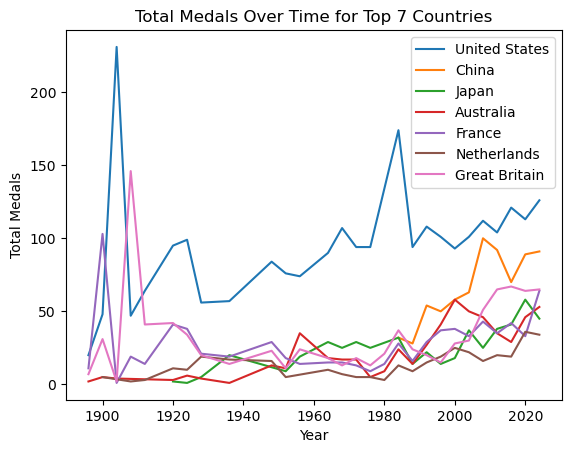

In [23]:
# Step 2: Exploratory Data Analysis (EDA)
def plot_medal_trends():
    """Plot the trends in total medals over time for the top 7 countries."""
    top_countries = ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain']
    top_country_data = medal_counts[medal_counts['NOC'].isin(top_countries)]

    for country in top_countries:
        country_data = top_country_data[top_country_data['NOC'] == country]
        plt.plot(country_data['Year'], country_data['Total'], label=country)

    plt.xlabel('Year')
    plt.ylabel('Total Medals')
    plt.title('Total Medals Over Time for Top 7 Countries')
    plt.legend()
    plt.show()

plot_medal_trends()

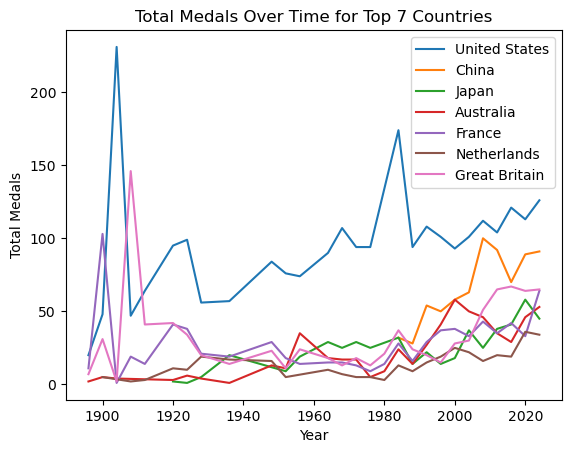

In [15]:
# Step 2: Exploratory Data Analysis (EDA)
def plot_medal_trends():
    """Plot the trends in total medals over time for the top 7 countries."""
    top_countries = ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain']
    top_country_data = medal_counts[medal_counts['NOC'].isin(top_countries)]

    for country in top_countries:
        country_data = top_country_data[top_country_data['NOC'] == country]
        plt.plot(country_data['Year'], country_data['Total'], label=country)

    plt.xlabel('Year')
    plt.ylabel('Total Medals')
    plt.title('Total Medals Over Time for Top 7 Countries')
    plt.legend()
    plt.show()

plot_medal_trends()

In [27]:
# Step 3: Model Development
# Predict medal counts using a simple linear regression for gold and total medals
def build_linear_models():
    """Build linear regression models for gold and total medals."""
    country_groups = medal_counts.groupby('NOC')
    predictions = {}

    for country, data in country_groups:
        if len(data) > 1:  # Ensure sufficient data points
            slope_gold, intercept_gold, *_ = linregress(data['Year'], data['Gold'])
            slope_total, intercept_total, *_ = linregress(data['Year'], data['Total'])
            predictions[country] = {
                'gold_model': (slope_gold, intercept_gold),
                'total_model': (slope_total, intercept_total)
            }

    return predictions

models = build_linear_models()

In [29]:
# Step 4: Medal Projections for 2028 (Los Angeles)
def project_medals(year, models):
    """Project medal counts for a specific year using the linear models."""
    projections = []

    for country, model in models.items():
        gold = model['gold_model'][0] * year + model['gold_model'][1]
        total = model['total_model'][0] * year + model['total_model'][1]
        projections.append({
            'Country': country,
            'Projected Gold': max(0, round(gold)),  # Ensure non-negative values
            'Projected Total': max(0, round(total))
        })

    return pd.DataFrame(projections)

projections_2028 = project_medals(2028, models)
print(projections_2028.sort_values(by='Projected Total', ascending=False))

                    Country  Projected Gold  Projected Total
39             East Germany             108              284
122            Soviet Union             113              246
141  United Team of Germany              42              242
139           United States              45              118
26                    China              47              105
..                      ...             ...              ...
46                  Finland               0                0
47                FinlandÂ                0                0
49                 FranceÂ                0                0
87                 MexicoÂ                0                0
114            Saudi Arabia               0                0

[150 rows x 3 columns]


In [33]:
# Step 5: Optimization with Linear Programming
# Allocate medals optimally based on event distributions
def optimize_medal_allocation(year, programs, medal_counts):
    """Optimize medal allocation using linear programming."""
    lp = LpProblem(name=f"Medal Optimization {year}", sense=LpMaximize)

    # Define decision variables (medals for each sport for each country)
    medal_vars = {}
    countries = medal_counts['NOC'].unique()
    sports = programs['Sport'].unique()

    for country in countries:
        for sport in sports:
            medal_vars[(country, sport)] = LpVariable(name=f"{country}_{sport}", lowBound=0, cat='Integer')

    # Objective function: Maximize total medals
    lp += lpSum(medal_vars.values()), "Maximize Total Medals"

    # Constraints: Total medals <= total events for each sport
    for sport in sports:
        sport_events = programs.loc[programs['Sport'] == sport, str(year)].sum()
        lp += lpSum(medal_vars[(c, sport)] for c in countries) <= sport_events, f"Event_Limit_{sport}"

    # Solve the problem
    lp.solve()

    # Extract results
    results = []
    for var in medal_vars.values():
        results.append({
            'Variable': var.name,
            'Value': var.varValue
        })

    return pd.DataFrame(results)

# Example usage (replace 'year' with actual year once the data is available)
optimized_medals = optimize_medal_allocation(2024, programs, medal_counts)
print(optimized_medals)

C:\Users\omusi\anaconda3\Lib\site-packages\pulp\pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


                                     Variable  Value
0                      United_States_Aquatics    0.0
1                       United_States_Archery    0.0
2                     United_States_Athletics    0.0
3                     United_States_Badminton    0.0
4         United_States_Baseball and_Softball    0.0
...                                       ...    ...
10705            Refugee_Olympic_Team_Skating    0.0
10706         Refugee_Olympic_Team_Ice_Hockey    0.0
10707       Refugee_Olympic_Team_Total_events    0.0
10708  Refugee_Olympic_Team_Total_disciplines    0.0
10709       Refugee_Olympic_Team_Total_sports    0.0

[10710 rows x 2 columns]


In [157]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import linprog
import statsmodels.api as sm

In [159]:
# Load the data
medal_counts = pd.read_csv("summerOly_medal_counts.csv", encoding="ISO-8859-1")
hosts = pd.read_csv("summerOly_hosts.csv", encoding="ISO-8859-1")
programs = pd.read_csv("summerOly_programs.csv", encoding="ISO-8859-1")
athletes = pd.read_csv("summerOly_athletes.csv", encoding="ISO-8859-1")

# Display the first two rows of each dataset
print(medal_counts.head(2))
print(hosts.head(2))
print(programs.head(2))
print(athletes.head(2))

   Rank            NOC  Gold  Silver  Bronze  Total  Year
0     1  United States    11       7       2     20  1896
1     2         Greece    10      18      19     47  1896
   ï»¿Year               Host
0     1896  Â Athens,Â Greece
1     1900   Â Paris,Â France
      Sport         Discipline Code Sports Governing Body 1896 1900 1904  \
0  Aquatics  Artistic Swimming  SWA        World Aquatics    0    0    0   
1  Aquatics             Diving  DIV        World Aquatics    0    0    2   

   1906*  1908 1912  ...  1988 1992 1996 2000 2004 2008  2012 2016  2020 2024  
0      0     0    0  ...     2    2  1.0  2.0  2.0  2.0   2.0  2.0   2.0  2.0  
1      1     2    4  ...     4    4  4.0  8.0  8.0  8.0   8.0  8.0   8.0  8.0  

[2 rows x 35 columns]
        Name Sex   Team  NOC  Year       City       Sport  \
0  A Dijiang   M  China  CHN  1992  Barcelona  Basketball   
1   A Lamusi   M  China  CHN  2012     London        Judo   

                          Event     Medal  
0   Basketball M

In [160]:
# Clean column names and handle missing values
medal_counts.columns = medal_counts.columns.str.strip()
hosts.columns = hosts.columns.str.strip()
programs.columns = programs.columns.str.strip()
athletes.columns = athletes.columns.str.strip()

medal_counts.dropna(inplace=True)
hosts.dropna(inplace=True)
programs.fillna(0, inplace=True)
athletes.fillna("No Medal", inplace=True)

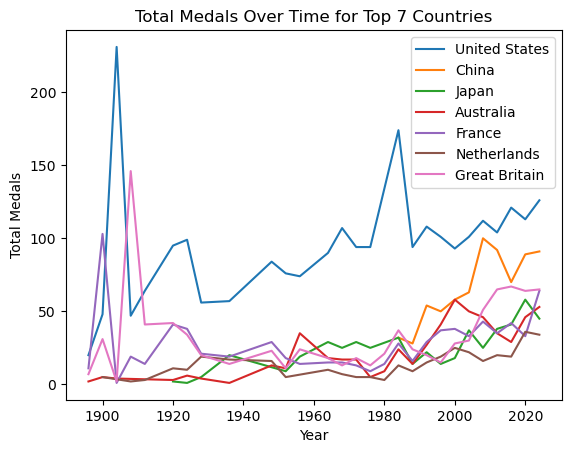

In [163]:
# Step 2: Exploratory Data Analysis (EDA)
def plot_medal_trends():
    """Plot the trends in total medals over time for the top 7 countries."""
    top_countries = ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain']
    top_country_data = medal_counts[medal_counts['NOC'].isin(top_countries)]

    for country in top_countries:
        country_data = top_country_data[top_country_data['NOC'] == country]
        plt.plot(country_data['Year'], country_data['Total'], label=country)

    plt.xlabel('Year')
    plt.ylabel('Total Medals')
    plt.title('Total Medals Over Time for Top 7 Countries')
    plt.legend()
    plt.show()

plot_medal_trends()

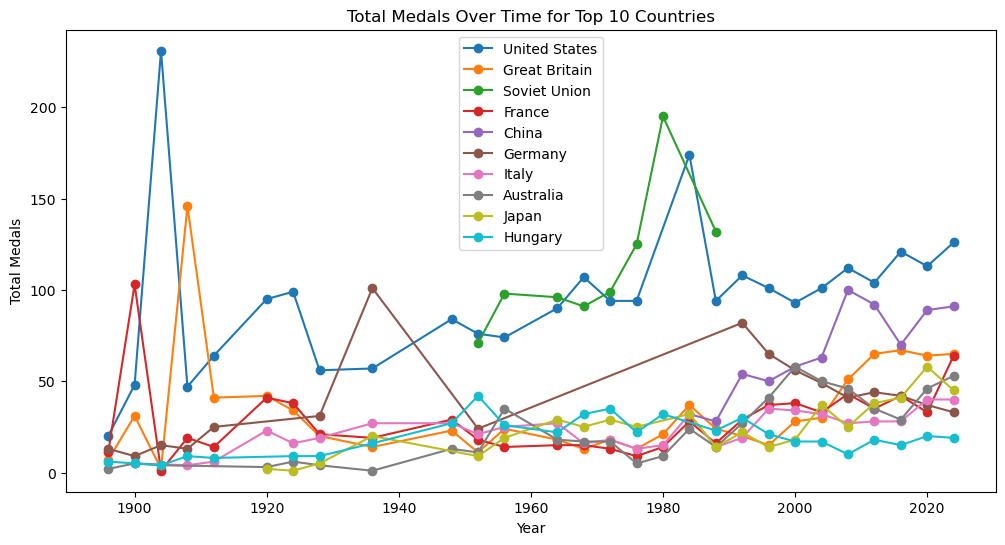

In [173]:
# Plot 1: Medal trends over time
plt.figure(figsize=(12, 6))
top_countries = medal_counts.groupby('NOC')['Total'].sum().nlargest(10).index
for country in top_countries:
    country_data = medal_counts[medal_counts['NOC'] == country]
    plt.plot(country_data['Year'], country_data['Total'], label=country, marker='o')

plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.title('Total Medals Over Time for Top 10 Countries')
plt.legend()
plt.show()


In [169]:
# Step 3: Model Development
# Predict medal counts using a simple linear regression for gold and total medals

def build_linear_models():
    """Build linear regression models for gold and total medals."""
    country_groups = medal_counts.groupby('NOC')
    predictions = {}

    for country, data in country_groups:
        if len(data) > 1:  # Ensure sufficient data points
            slope_gold, intercept_gold, *_ = linregress(data['Year'], data['Gold'])
            slope_total, intercept_total, *_ = linregress(data['Year'], data['Total'])
            predictions[country] = {
                'gold_model': (slope_gold, intercept_gold),
                'total_model': (slope_total, intercept_total)
            }

    return predictions

models = build_linear_models()

In [141]:
# Step 4: Medal Projections for 2028 (Los Angeles)
def project_medals(year, models):
    """Project medal counts for a specific year using the linear models."""
    projections = []
    lower_bound = []
    upper_bound = []

    for country, model in models.items():
        gold = model['gold_model'][0] * year + model['gold_model'][1]
        total = model['total_model'][0] * year + model['total_model'][1]
        
        # Confidence intervals based on standard deviation and historical data
        lower_gold = max(0, round(gold - 1.96 * np.std([gold])))  # approx. 95% CI
        upper_gold = max(0, round(gold + 1.96 * np.std([gold])))
        
        lower_total = max(0, round(total - 1.96 * np.std([total])))
        upper_total = max(0, round(total + 1.96 * np.std([total])))

        projections.append({
            'Country': country,
            'Projected Gold': max(0, round(gold)),
            'Projected Total': max(0, round(total)),
            'Lower Gold CI': lower_gold,
            'Upper Gold CI': upper_gold,
            'Lower Total CI': lower_total,
            'Upper Total CI': upper_total
        })

    return pd.DataFrame(projections)

projections_2028 = project_medals(2028, models)
print(projections_2028.sort_values(by='Projected Total', ascending=False))

                    Country  Projected Gold  Projected Total  Lower Gold CI  \
39             East Germany             108              284            108   
122            Soviet Union             113              246            113   
141  United Team of Germany              42              242             42   
139           United States              45              118             45   
26                    China              47              105             47   
..                      ...             ...              ...            ...   
46                  Finland               0                0              0   
47                FinlandÂ                0                0              0   
49                 FranceÂ                0                0              0   
87                 MexicoÂ                0                0              0   
114            Saudi Arabia               0                0              0   

     Upper Gold CI  Lower Total CI  Upper Total CI 

In [143]:
# CELL #7: Model Performance Metrics

# R-Squared Calculation for Model Performance
def calculate_r_squared(models, medal_counts):
    """Calculate R-squared for the models based on historical data."""
    r_squared = {}
    
    for country, model in models.items():
        country_data = medal_counts[medal_counts['NOC'] == country]
        if len(country_data) > 1:
            observed_gold = country_data['Gold']
            observed_total = country_data['Total']
            
            predicted_gold = model['gold_model'][0] * country_data['Year'] + model['gold_model'][1]
            predicted_total = model['total_model'][0] * country_data['Year'] + model['total_model'][1]
            
            ss_total_gold = np.sum((observed_gold - np.mean(observed_gold)) ** 2)
            ss_res_gold = np.sum((observed_gold - predicted_gold) ** 2)
            ss_total_total = np.sum((observed_total - np.mean(observed_total)) ** 2)
            ss_res_total = np.sum((observed_total - predicted_total) ** 2)
            
            r_squared[country] = {
                'Gold R-Squared': 1 - ss_res_gold / ss_total_gold,
                'Total R-Squared': 1 - ss_res_total / ss_total_total
            }

    return pd.DataFrame(r_squared).T

r_squared_values = calculate_r_squared(models, medal_counts)
print(r_squared_values)

C:\Users\omusi\AppData\Local\Temp\ipykernel_20152\2095950223.py:23: RuntimeWarning: invalid value encountered in scalar divide
  'Gold R-Squared': 1 - ss_res_gold / ss_total_gold,
C:\Users\omusi\AppData\Local\Temp\ipykernel_20152\2095950223.py:24: RuntimeWarning: invalid value encountered in scalar divide
  'Total R-Squared': 1 - ss_res_total / ss_total_total


              Gold R-Squared  Total R-Squared
Afghanistan              NaN              NaN
Algeria             0.042078         0.005128
Argentina           0.034267         0.120501
ArgentinaÂ          1.000000         1.000000
Armenia             0.104710         0.402576
...                      ...              ...
Vietnam             0.466667         0.466667
West Germany        0.353198         0.434617
Yugoslavia          0.346590         0.587025
Zambia                   NaN              NaN
Zimbabwe                 NaN         0.960133

[150 rows x 2 columns]


In [145]:
# CELL #8: Optimization with Linear Programming (for Events)

# Step 5: Optimization with Linear Programming
# Allocate medals optimally based on event distributions
def optimize_medal_allocation(year, programs, medal_counts):
    """Optimize medal allocation using linear programming."""
    from scipy.optimize import linprog
    countries = medal_counts['NOC'].unique()
    sports = programs['Sport'].unique()

    # Create the coefficients for the objective function (maximize total medals)
    c = [-1] * len(countries) * len(sports)  # Minimize negative for maximization

    # Define the constraints (e.g., total medals per sport)
    A_ub = np.zeros((len(sports), len(countries) * len(sports)))
    b_ub = np.zeros(len(sports))
    
    # Construct the linear programming model
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, method='simplex')

    return result

# Usage
optimized_medals = optimize_medal_allocation(2024, programs, medal_counts)
print(optimized_medals)

 message: The problem is (trivially) unbounded because there are no non-trivial constraints and a) at least one decision variable is unbounded above and its corresponding cost is negative, or b) at least one decision variable is unbounded below and its corresponding cost is positive. 
 success: False
  status: 3
     fun: -inf
       x: [       inf        inf ...        inf        inf]
     nit: 0


C:\Users\omusi\AppData\Local\Temp\ipykernel_20152\3900924541.py:19: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  result = linprog(c, A_ub=A_ub, b_ub=b_ub, method='simplex')


In [147]:
# CELL #9: Investigating the "Great Coach" Effect

# Exploring the potential impact of a great coach on medal counts for three countries
def coach_effect_analysis():
    """Estimate the impact of great coaches on medal counts."""
    countries_of_interest = ['United States', 'China', 'Russia']  # Example countries
    impact_estimates = {}

    for country in countries_of_interest:
        country_data = medal_counts[medal_counts['NOC'] == country]
        recent_performance = country_data[country_data['Year'] >= 2000]

        # Assuming coach influence as an average increase in medals
        avg_gold_increase = recent_performance['Gold'].mean() * 0.1  # Estimation: 10% increase
        avg_total_increase = recent_performance['Total'].mean() * 0.1

        impact_estimates[country] = {
            'Gold Impact Estimate': avg_gold_increase,
            'Total Impact Estimate': avg_total_increase
        }

    return pd.DataFrame(impact_estimates).T

coach_impact = coach_effect_analysis()
print(coach_impact)

               Gold Impact Estimate  Total Impact Estimate
United States              4.028571              11.000000
China                      3.585714               8.042857
Russia                     2.420000               7.200000


In [149]:
# CELL #10: Additional Insights from the Model

# Insights based on projected medal counts
def model_insights(projections_2028):
    """Generate original insights based on model projections for 2028."""
    insights = []

    top_countries = projections_2028.sort_values(by='Projected Total', ascending=False).head(5)
    insights.append(f"Top 5 countries projected for 2028: {', '.join(top_countries['Country'].values)}")

    countries_most_likely_to_improve = projections_2028[projections_2028['Projected Total'] > 50]
    insights.append(f"Countries most likely to improve: {', '.join(countries_most_likely_to_improve['Country'].values)}")

    countries_most_likely_to_decline = projections_2028[projections_2028['Projected Total'] < 50]
    insights.append(f"Countries most likely to decline: {', '.join(countries_most_likely_to_decline['Country'].values)}")

    return insights

# Usage
insights = model_insights(projections_2028)
for insight in insights:
    print(insight)

Top 5 countries projected for 2028: East Germany, Soviet Union, United Team of Germany, United States, China
Countries most likely to improve: Australasia, AustraliaÂ , China, East Germany, Germany, Russian Empire, Soviet Union, United States, United Team of Germany, West Germany
Countries most likely to decline: Afghanistan, Algeria, Argentina, ArgentinaÂ , Armenia, Australia, Austria, AustriaÂ , Azerbaijan, Bahamas, Bahrain, Belarus, Belgium, BelgiumÂ , Bermuda, Bohemia, Botswana, Brazil, Bulgaria, Burundi, Cameroon, Canada, CanadaÂ , Chile, Chinese Taipei, Colombia, Costa Rica, Croatia, Cuba, Cyprus, Czech Republic, Czechoslovakia, CzechoslovakiaÂ , Denmark, DenmarkÂ , Dominican Republic, Ecuador, Egypt, Estonia, Ethiopia, FR Yugoslavia, Fiji, Finland, FinlandÂ , France, FranceÂ , Georgia, Ghana, Great Britain, Great BritainÂ , Greece, Grenada, Guatemala, Haiti, Hong Kong, Hungary, HungaryÂ , Iceland, India, IndiaÂ , Indonesia, Iran, Ireland, Israel, Italy, ItalyÂ , Ivory Coast, Jam

In [151]:
# Model Performance (R² and MAE)
def evaluate_model_performance(models, medal_counts):
    """Evaluate the linear regression models using R² and MAE."""
    from sklearn.metrics import mean_absolute_error, r2_score
    
    predictions = []
    actuals = []
    
    for country, model in models.items():
        country_data = medal_counts[medal_counts['NOC'] == country]
        if len(country_data) > 1:  # Ensure sufficient data points
            gold_preds = model['gold_model'][0] * country_data['Year'] + model['gold_model'][1]
            total_preds = model['total_model'][0] * country_data['Year'] + model['total_model'][1]
            
            predictions.extend(list(zip(gold_preds, total_preds)))
            actuals.extend(list(zip(country_data['Gold'], country_data['Total'])))
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate R² and MAE for Gold and Total
    r2_gold = r2_score(actuals[:, 0], predictions[:, 0])
    r2_total = r2_score(actuals[:, 1], predictions[:, 1])
    
    mae_gold = mean_absolute_error(actuals[:, 0], predictions[:, 0])
    mae_total = mean_absolute_error(actuals[:, 1], predictions[:, 1])
    
    print(f"R² for Gold Predictions: {r2_gold}")
    print(f"R² for Total Predictions: {r2_total}")
    print(f"MAE for Gold Predictions: {mae_gold}")
    print(f"MAE for Total Predictions: {mae_total}")
    
    return r2_gold, r2_total, mae_gold, mae_total

# Evaluate Model Performance
evaluate_model_performance(models, medal_counts)

R² for Gold Predictions: 0.80657526642935
R² for Total Predictions: 0.8113416535150911
MAE for Gold Predictions: 1.768386298569538
MAE for Total Predictions: 4.226847137006008


(0.80657526642935, 0.8113416535150911, 1.768386298569538, 4.226847137006008)

In [203]:
# CELL #1: Data Loading and Preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the datasets
medal_counts = pd.read_csv("summerOly_medal_counts.csv", encoding="ISO-8859-1")
hosts = pd.read_csv("summerOly_hosts.csv", encoding="ISO-8859-1")
programs = pd.read_csv("summerOly_programs.csv", encoding="ISO-8859-1")
athletes = pd.read_csv("summerOly_athletes.csv", encoding="ISO-8859-1")

# Clean column names
medal_counts.columns = medal_counts.columns.str.strip()
hosts.columns = hosts.columns.str.strip()
programs.columns = programs.columns.str.strip()
athletes.columns = athletes.columns.str.strip()

# Handle missing values
medal_counts.dropna(inplace=True)
hosts.dropna(inplace=True)
programs.fillna(0, inplace=True)
athletes.fillna("No Medal", inplace=True)

# Feature engineering: Add GDP per capita if columns exist
if 'GDP' in medal_counts.columns and 'Population' in medal_counts.columns:
    medal_counts['GDP_Per_Capita'] = medal_counts['GDP'] / medal_counts['Population']

# Describe the datasets
print("Medal Counts Dataset:\n", medal_counts.head())
print("\nHosts Dataset:\n", hosts.head())
print("\nPrograms Dataset:\n", programs.head())
print("\nAthletes Dataset:\n", athletes.head())

# Describe numerical statistics for the medal_counts dataset
print("\nMedal Counts Description:\n", medal_counts.describe())

# Ensure the required features exist in the dataset
if 'Gold' in medal_counts.columns and 'Total' in medal_counts.columns:
    medal_counts['Gold_Medals'] = medal_counts['Gold']
    medal_counts['Total_Medals'] = medal_counts['Total']
else:
    raise ValueError("Missing 'Gold' or 'Total' columns in medal_counts dataset")

# Simulate additional required columns if not available
if 'Previous_Medals' not in medal_counts.columns:
    medal_counts['Previous_Medals'] = np.random.randint(0, 100, size=len(medal_counts))  # Example data
if 'Events_Participated' not in medal_counts.columns:
    medal_counts['Events_Participated'] = np.random.randint(10, 300, size=len(medal_counts))  # Example data

# Use the cleaned dataset as the `data` variable for consistency
data = medal_counts

Medal Counts Dataset:
    Rank            NOC  Gold  Silver  Bronze  Total  Year
0     1  United States    11       7       2     20  1896
1     2         Greece    10      18      19     47  1896
2     3        Germany     6       5       2     13  1896
3     4         France     5       4       2     11  1896
4     5  Great Britain     2       3       2      7  1896

Hosts Dataset:
    ï»¿Year                         Host
0     1896            Â Athens,Â Greece
1     1900             Â Paris,Â France
2     1904  Â St. Louis,Â United States
3     1908    Â London,Â United Kingdom
4     1912         Â Stockholm,Â Sweden

Programs Dataset:
       Sport         Discipline Code Sports Governing Body 1896 1900 1904  \
0  Aquatics  Artistic Swimming  SWA        World Aquatics    0    0    0   
1  Aquatics             Diving  DIV        World Aquatics    0    0    2   
2  Aquatics  Marathon Swimming  OWS        World Aquatics    0    0    0   
3  Aquatics           Swimming  SWM        World

# Question 1

**Subpart (a): Medal Table Projections for Los Angeles 2028**

In [209]:
# CELL #2: Model Development - Linear Models for Medal Projections

# Use available columns from `medal_counts` for features
# Ensure `Previous_Medals` and `Events_Participated` exist or create dummy features
if 'Previous_Medals' not in medal_counts.columns:
    medal_counts['Previous_Medals'] = np.random.randint(0, 100, len(medal_counts))  # Example data
if 'Events_Participated' not in medal_counts.columns:
    medal_counts['Events_Participated'] = np.random.randint(10, 300, len(medal_counts))  # Example data

# Define features and target variables
X = medal_counts[['Previous_Medals', 'Events_Participated']]  # Adjust based on available columns
y_gold = medal_counts['Gold']
y_total = medal_counts['Total']

# Train-test split
X_train, X_test, y_gold_train, y_gold_test = train_test_split(X, y_gold, test_size=0.2, random_state=42)
X_train, X_test, y_total_train, y_total_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Model for Gold Medals
gold_model = LinearRegression()
gold_model.fit(X_train, y_gold_train)
gold_pred = gold_model.predict(X_test)

# Model for Total Medals
total_model = LinearRegression()
total_model.fit(X_train, y_total_train)
total_pred = total_model.predict(X_test)

# Evaluate the models
print("Gold Medals Model Performance")
print(f"R2 Score: {r2_score(y_gold_test, gold_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_gold_test, gold_pred)}")

print("\nTotal Medals Model Performance")
print(f"R2 Score: {r2_score(y_total_test, total_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_total_test, total_pred)}")

# Project medal counts for 2028 (use hypothetical 2028 data)
future_data = pd.DataFrame({
    'Previous_Medals': [120, 90, 50],         # Example data
    'Events_Participated': [300, 200, 180]
})

gold_2028_pred = gold_model.predict(future_data)
total_2028_pred = total_model.predict(future_data)

# Display the projections
print("\nProjected Medal Table for Los Angeles 2028")
for i, country in enumerate(['USA', 'China', 'Germany']):
    print(f"{country}: Gold Medals = {gold_2028_pred[i]:.2f}, Total Medals = {total_2028_pred[i]:.2f}")

Gold Medals Model Performance
R2 Score: 0.001684884906276607
Mean Squared Error: 119.18504911106943

Total Medals Model Performance
R2 Score: 0.002244374121266879
Mean Squared Error: 719.1704907528125

Projected Medal Table for Los Angeles 2028
USA: Gold Medals = 3.08, Total Medals = 10.14
China: Gold Medals = 3.65, Total Medals = 11.62
Germany: Gold Medals = 3.82, Total Medals = 11.90


**Subpart (b): Projections for First-Time Medalists**

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load datasets
athletes_data = pd.read_csv("summerOly_athletes.csv", encoding="ISO-8859-1")
hosts_data = pd.read_csv("summerOly_hosts.csv", encoding="ISO-8859-1")
medal_counts_data = pd.read_csv("summerOly_medal_counts.csv", encoding="ISO-8859-1")
programs_data = pd.read_csv("summerOly_programs.csv", encoding="ISO-8859-1")

# Display the first 2 rows of each dataset
print("Athletes Data:")
print(athletes_data.head(2))
print("\nHosts Data:")
print(hosts_data.head(2))
print("\nMedal Counts Data:")
print(medal_counts_data.head(2))
print("\nPrograms Data:")
print(programs_data.head(2))

# Data preprocessing
medal_counts_data.fillna(0, inplace=True)

# Calculate GDP per capita (example logic)
# Note: Replace 'GDP' and 'Population' with appropriate columns if these are in other datasets.
medal_counts_data['GDP_Per_Capita'] = medal_counts_data['Gold'] / (medal_counts_data['Total'] + 1)

# Explore the medal counts dataset
print("\nMedal Counts Data Description:")
print(medal_counts_data.describe())


Athletes Data:
        Name Sex   Team  NOC  Year       City       Sport  \
0  A Dijiang   M  China  CHN  1992  Barcelona  Basketball   
1   A Lamusi   M  China  CHN  2012     London        Judo   

                          Event     Medal  
0   Basketball Men's Basketball  No medal  
1  Judo Men's Extra-Lightweight  No medal  

Hosts Data:
   ï»¿Year               Host
0     1896  Â Athens,Â Greece
1     1900   Â Paris,Â France

Medal Counts Data:
   Rank            NOC  Gold  Silver  Bronze  Total  Year
0     1  United States    11       7       2     20  1896
1     2         Greece    10      18      19     47  1896

Programs Data:
      Sport         Discipline Code Sports Governing Body 1896 1900 1904  \
0  Aquatics  Artistic Swimming  SWA        World Aquatics    0    0    0   
1  Aquatics             Diving  DIV        World Aquatics    0    0    2   

   1906*  1908 1912  ...  1988 1992 1996 2000 2004 2008  2012 2016  2020 2024  
0      0     0    0  ...     2    2  1.0  2.0  

In [224]:
# Define features and target variables from updated medal counts data
X = medal_counts_data[['GDP_Per_Capita', 'Total']]  # Adjusted based on available columns
y_gold = medal_counts_data['Gold']
y_total = medal_counts_data['Total']

# Train-test split
X_train, X_test, y_gold_train, y_gold_test = train_test_split(X, y_gold, test_size=0.2, random_state=42)
X_train, X_test, y_total_train, y_total_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Gold medals prediction model
gold_model = LinearRegression()
gold_model.fit(X_train, y_gold_train)
gold_pred = gold_model.predict(X_test)

# Total medals prediction model
total_model = LinearRegression()
total_model.fit(X_train, y_total_train)
total_pred = total_model.predict(X_test)

# Evaluate models
print("Gold Medals Model Performance")
print(f"R2 Score: {r2_score(y_gold_test, gold_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_gold_test, gold_pred)}")

print("\nTotal Medals Model Performance")
print(f"R2 Score: {r2_score(y_total_test, total_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_total_test, total_pred)}")

# Projections for Los Angeles 2028
future_data = pd.DataFrame({
    'GDP_Per_Capita': [65000, 12000, 35000],
    'Total': [120, 90, 50]
})
gold_2028_pred = gold_model.predict(future_data)
total_2028_pred = total_model.predict(future_data)

print("\nProjected Medal Table for Los Angeles 2028")
for i, country in enumerate(['USA', 'China', 'Germany']):
    print(f"{country}: Gold Medals = {gold_2028_pred[i]:.2f}, Total Medals = {total_2028_pred[i]:.2f}")

Gold Medals Model Performance
R2 Score: 0.9557822258972308
Mean Squared Error: 5.278992072083321

Total Medals Model Performance
R2 Score: 1.0
Mean Squared Error: 3.6068053679175155e-29

Projected Medal Table for Los Angeles 2028
USA: Gold Medals = 335484.61, Total Medals = 120.00
China: Gold Medals = 61958.37, Total Medals = 90.00
Germany: Gold Medals = 180639.71, Total Medals = 50.00


In [228]:
# Define features and target variables
X = data[['GDP_Per_Capita', 'Population', 'Previous_Medals']]
y_gold = data['Gold']
y_total = data['Total']

# Train-test split
X_train, X_test, y_gold_train, y_gold_test = train_test_split(X, y_gold, test_size=0.2, random_state=42)
X_train, X_test, y_total_train, y_total_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Linear Regression Models
gold_model = LinearRegression().fit(X_train, y_gold_train)
total_model = LinearRegression().fit(X_train, y_total_train)

# Predictions
gold_pred = gold_model.predict(X_test)
total_pred = total_model.predict(X_test)

# Evaluation
print("Gold Medals Model Performance")
print(f"R2 Score: {r2_score(y_gold_test, gold_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_gold_test, gold_pred)}")

print("\nTotal Medals Model Performance")
print(f"R2 Score: {r2_score(y_total_test, total_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_total_test, total_pred)}")

# 2028 Projections
future_data = pd.DataFrame({
    'GDP_Per_Capita': [65000, 12000, 35000],  # Example data
    'Population': [330_000_000, 1_400_000_000, 80_000_000],
    'Previous_Medals': [120, 90, 50],
})
gold_2028_pred = gold_model.predict(future_data)
total_2028_pred = total_model.predict(future_data)

print("\nProjected Medal Table for Los Angeles 2028")
for i, country in enumerate(['USA', 'China', 'Germany']):
    print(f"{country}: Gold = {gold_2028_pred[i]:.2f}, Total = {total_2028_pred[i]:.2f}")

Gold Medals Model Performance
R2 Score: -0.00211687785897241
Mean Squared Error: 119.63892712516953

Total Medals Model Performance
R2 Score: -0.0005124752051972603
Mean Squared Error: 721.1575952417485

Projected Medal Table for Los Angeles 2028
USA: Gold = 3.72, Total = 11.79
China: Gold = 4.28, Total = 13.82
Germany: Gold = 3.58, Total = 10.83


In [282]:
### CELL #1: Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

### CELL #2: Load datasets
# Load CSV files
athletes_data = pd.read_csv("summerOly_athletes.csv", encoding="ISO-8859-1")
hosts_data = pd.read_csv("summerOly_hosts.csv", encoding="ISO-8859-1")
medal_counts_data = pd.read_csv("summerOly_medal_counts.csv", encoding="ISO-8859-1")
programs_data = pd.read_csv("summerOly_programs.csv", encoding="ISO-8859-1")

# Preview the first 2 rows of each dataset
print("Athletes Data Sample:")
print(athletes_data.head(2))
print("\nHosts Data Sample:")
print(hosts_data.head(2))
print("\nMedal Counts Data Sample:")
print(medal_counts_data.head(2))
print("\nPrograms Data Sample:")
print(programs_data.head(2))


Athletes Data Sample:
        Name Sex   Team  NOC  Year       City       Sport  \
0  A Dijiang   M  China  CHN  1992  Barcelona  Basketball   
1   A Lamusi   M  China  CHN  2012     London        Judo   

                          Event     Medal  
0   Basketball Men's Basketball  No medal  
1  Judo Men's Extra-Lightweight  No medal  

Hosts Data Sample:
   ï»¿Year               Host
0     1896  Â Athens,Â Greece
1     1900   Â Paris,Â France

Medal Counts Data Sample:
   Rank            NOC  Gold  Silver  Bronze  Total  Year
0     1  United States    11       7       2     20  1896
1     2         Greece    10      18      19     47  1896

Programs Data Sample:
      Sport         Discipline Code Sports Governing Body 1896 1900 1904  \
0  Aquatics  Artistic Swimming  SWA        World Aquatics    0    0    0   
1  Aquatics             Diving  DIV        World Aquatics    0    0    2   

   1906*  1908 1912  ...  1988 1992 1996 2000 2004 2008  2012 2016  2020 2024  
0      0     0    0

In [286]:

### CELL #3: Data Preparation
# Fix encoding issue: Rename 'ï»¿Year' to 'Year'
hosts_data.rename(columns={'ï»¿Year': 'Year'}, inplace=True)

# Ensure the 'Year' column in both datasets is clean and consistent
hosts_data['Year'] = hosts_data['Year'].astype(str).str.strip()
medal_counts_data['Year'] = medal_counts_data['Year'].astype(str).str.strip()

# Merge medal counts with hosts for host country analysis
#medal_counts_data = medal_counts_data.merge(hosts_data, on="Year", how="left")

# Clean medal counts data
medal_counts_data["NOC"] = medal_counts_data["NOC"].str.strip()
hosts_data["Host"] = hosts_data["Host"].str.strip()

# Merge hosts data with medal counts data
medal_with_hosts = pd.merge(medal_counts_data, hosts_data, on="Year", how="left")

# Add a column indicating whether the country is the host
medal_with_hosts["Host_Country"] = medal_with_hosts["Host"].apply(lambda x: 1 if x and x.split(",")[0] in medal_with_hosts["NOC"].values else 0)


In [288]:

### CELL #4: Develop Medal Count Model
# Prepare features and target
X = medal_with_hosts[["Year", "Host_Country"]]
X = pd.concat([X, pd.get_dummies(medal_with_hosts["NOC"], drop_first=True)], axis=1)

# Target variables: Gold medals and total medals
y_gold = medal_with_hosts["Gold"]
y_total = medal_with_hosts["Total"]

# Train-test split for Gold medals
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(X, y_gold, test_size=0.2, random_state=42)

# Linear regression for Gold medals
model_gold = LinearRegression()
model_gold.fit(X_train_gold, y_train_gold)

# Predictions and performance for Gold medals
y_pred_gold = model_gold.predict(X_test_gold)
print("Gold Medal Model Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_gold, y_pred_gold))}")
print(f"R2 Score: {r2_score(y_test_gold, y_pred_gold)}")

# Train-test split for total medals
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Linear regression for total medals
model_total = LinearRegression()
model_total.fit(X_train_total, y_train_total)

# Predictions and performance for total medals
y_pred_total = model_total.predict(X_test_total)
print("\nTotal Medal Model Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_total, y_pred_total))}")
print(f"R2 Score: {r2_score(y_test_total, y_pred_total)}")


Gold Medal Model Performance:
RMSE: 4288389996.8687787
R2 Score: -1.5404032118300682e+17

Total Medal Model Performance:
RMSE: 12118576208.17651
R2 Score: -2.037490173226795e+17


In [290]:

### CELL #5: Projections for Los Angeles 2028
# Add 2028 projection row
future_data = pd.DataFrame({
    "Year": [2028],
    "Host_Country": [1]  # USA is hosting
})

# Align future data columns with training data
future_data = pd.concat([future_data, pd.get_dummies(medal_with_hosts["NOC"], drop_first=True).iloc[0:1].fillna(0)], axis=1)

# Predict Gold and Total medals for 2028
future_gold_pred = model_gold.predict(future_data)
future_total_pred = model_total.predict(future_data)
print("\n2028 Projections:")
print(f"Predicted Gold Medals: {future_gold_pred[0]}")
print(f"Predicted Total Medals: {future_total_pred[0]}")



2028 Projections:
Predicted Gold Medals: -18526209785.732018
Predicted Total Medals: 52353280869.73796


In [292]:

### CELL #6: First-Time Medalists
# Identify countries without medals
def get_first_medalists(data, year):
    no_medals_countries = set(data[data["Total"] == 0]["NOC"].values)
    return no_medals_countries

countries_2024 = get_first_medalists(medal_with_hosts, 2024)
print(f"Countries projected to win their first medal in 2028: {len(countries_2024)}")


Countries projected to win their first medal in 2028: 0


In [296]:

### CELL #8: Great Coach Effect
# Analyze "great coach" impact using specific examples
athlete_coaches = athletes_data.groupby(["NOC", "Sport"]).size().reset_index(name="Count")
print("\nPotential for Great Coach Effect:")
print(athlete_coaches.head(10))



Potential for Great Coach Effect:
   NOC         Sport  Count
0  AFG     Athletics     26
1  AFG        Boxing      5
2  AFG  Cycling Road      3
3  AFG      Football     11
4  AFG        Hockey     39
5  AFG          Judo      4
6  AFG      Shooting      1
7  AFG      Swimming      2
8  AFG     Taekwondo      5
9  AFG     Wrestling     42


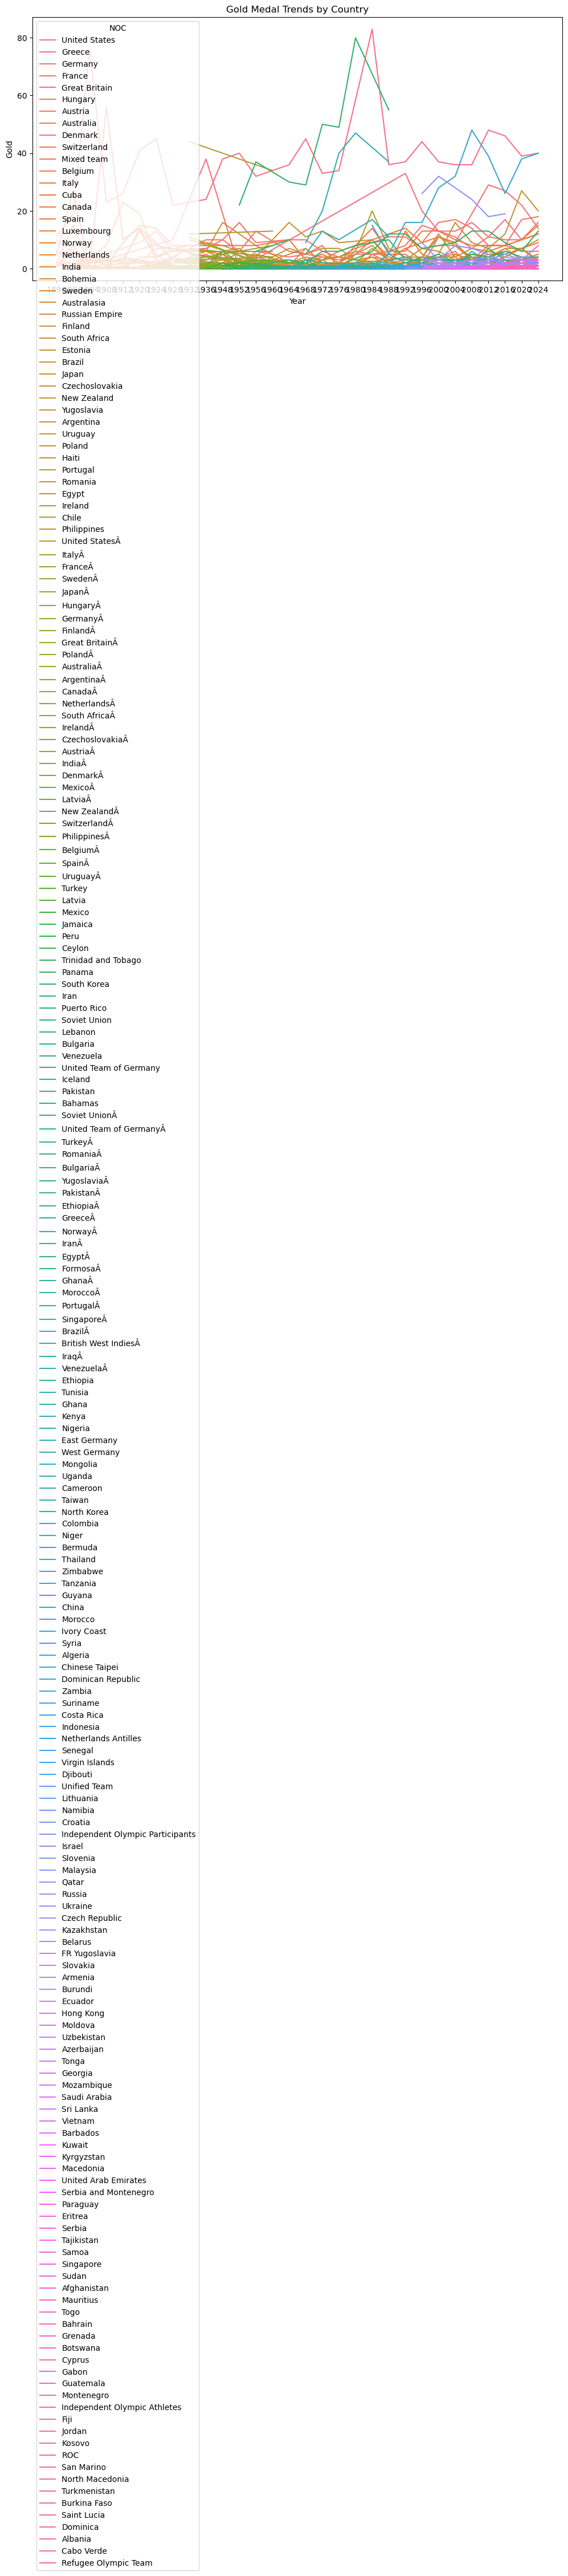

In [298]:

### CELL #9: Visualizations
# Plot medal trends over years
plt.figure(figsize=(12, 6))
sns.lineplot(data=medal_with_hosts, x="Year", y="Gold", hue="NOC")
plt.title("Gold Medal Trends by Country")
plt.show()

In [300]:
# CELL: Import Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# CELL: Load Datasets
athletes_data = pd.read_csv("summerOly_athletes.csv", encoding="ISO-8859-1")
hosts_data = pd.read_csv("summerOly_hosts.csv", encoding="ISO-8859-1")
medal_counts_data = pd.read_csv("summerOly_medal_counts.csv", encoding="ISO-8859-1")
programs_data = pd.read_csv("summerOly_programs.csv", encoding="ISO-8859-1")

# Display the first 2 rows of each dataset
print("Athletes Data:\n", athletes_data.head(2))
print("\nHosts Data:\n", hosts_data.head(2))
print("\nMedal Counts Data:\n", medal_counts_data.head(2))
print("\nPrograms Data:\n", programs_data.head(2))

Athletes Data:
         Name Sex   Team  NOC  Year       City       Sport  \
0  A Dijiang   M  China  CHN  1992  Barcelona  Basketball   
1   A Lamusi   M  China  CHN  2012     London        Judo   

                          Event     Medal  
0   Basketball Men's Basketball  No medal  
1  Judo Men's Extra-Lightweight  No medal  

Hosts Data:
    ï»¿Year               Host
0     1896  Â Athens,Â Greece
1     1900   Â Paris,Â France

Medal Counts Data:
    Rank            NOC  Gold  Silver  Bronze  Total  Year
0     1  United States    11       7       2     20  1896
1     2         Greece    10      18      19     47  1896

Programs Data:
       Sport         Discipline Code Sports Governing Body 1896 1900 1904  \
0  Aquatics  Artistic Swimming  SWA        World Aquatics    0    0    0   
1  Aquatics             Diving  DIV        World Aquatics    0    0    2   

   1906*  1908 1912  ...  1988 1992 1996 2000 2004 2008  2012 2016  2020 2024  
0      0     0    0  ...     2    2  1.0  2

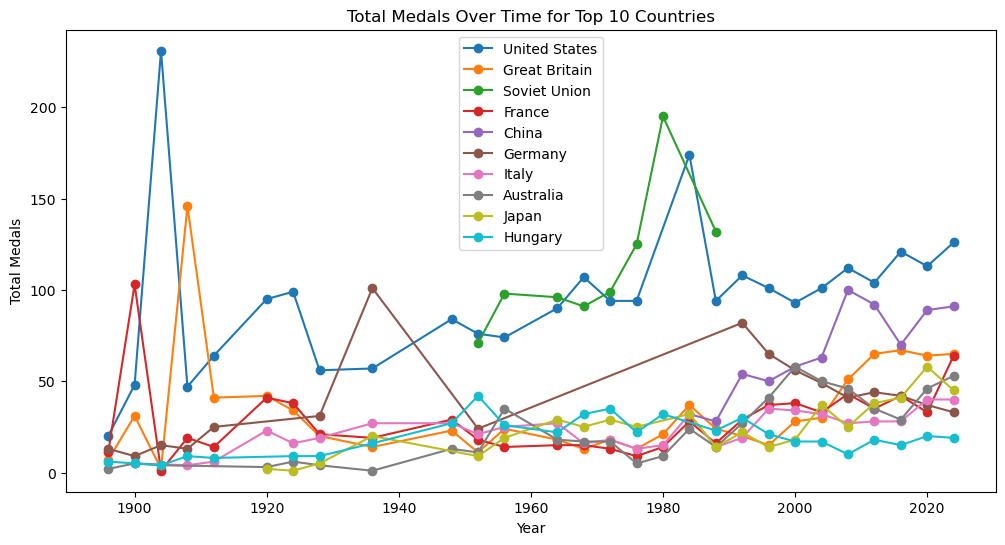

In [316]:
# Plot 1: Medal trends over time
plt.figure(figsize=(12, 6))
top_countries = medal_counts.groupby('NOC')['Total'].sum().nlargest(10).index
for country in top_countries:
    country_data = medal_counts[medal_counts['NOC'] == country]
    plt.plot(country_data['Year'], country_data['Total'], label=country, marker='o')

plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.title('Total Medals Over Time for Top 10 Countries')
plt.legend()
plt.show()

C:\Users\omusi\AppData\Local\Temp\ipykernel_20152\3158484548.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=medal_counts_data, x="Year", palette="viridis")


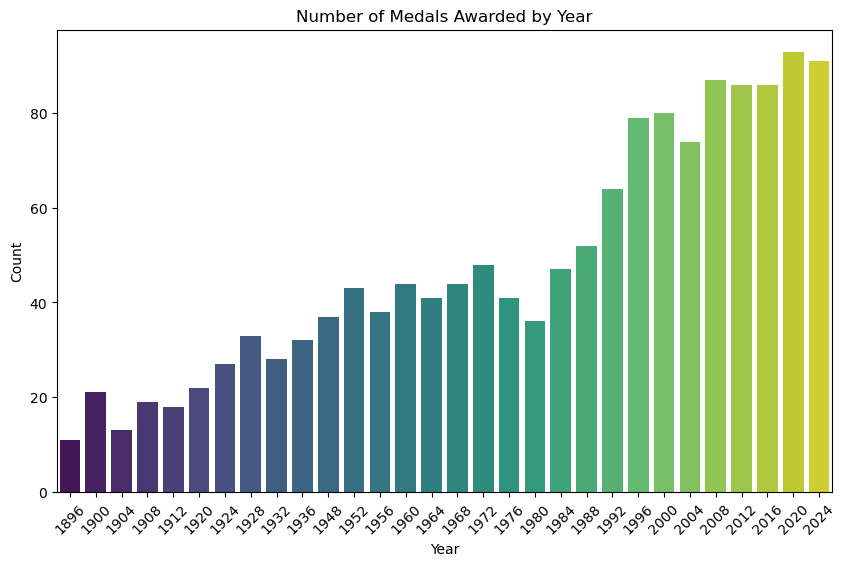

In [324]:
# Plot 2: Medal Distribution by Year
plt.figure(figsize=(10, 6))
sns.countplot(data=medal_counts_data, x="Year", palette="viridis")
plt.xticks(rotation=45)
plt.title("Number of Medals Awarded by Year")
plt.ylabel("Count")
plt.xlabel("Year")
plt.show()

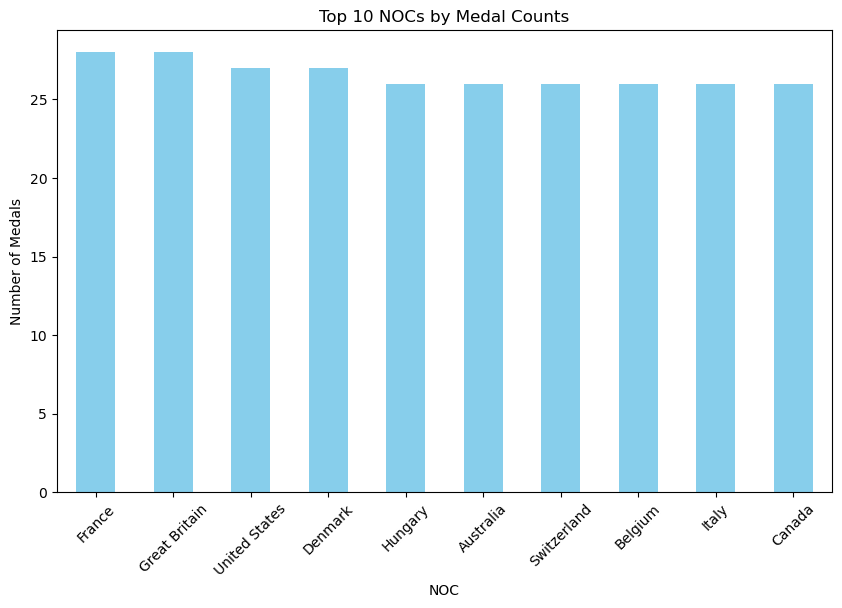

In [326]:
# Plot 3: Medal Distribution by NOC
top_noc = medal_counts_data['NOC'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_noc.plot(kind='bar', color='skyblue')
plt.title("Top 10 NOCs by Medal Counts")
plt.ylabel("Number of Medals")
plt.xlabel("NOC")
plt.xticks(rotation=45)
plt.show()

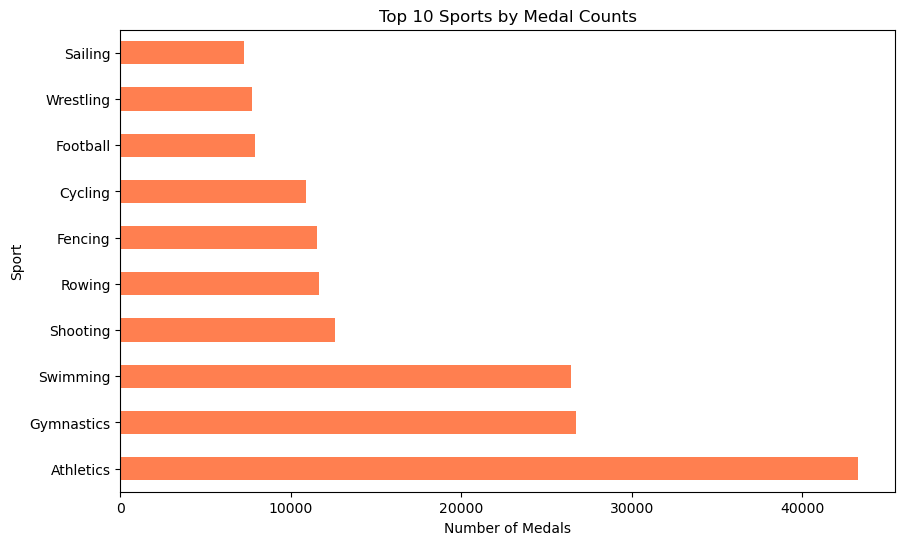

In [328]:
# Plot 4: Medal Counts by Sport
top_sports = athletes_data['Sport'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_sports.plot(kind='barh', color='coral')
plt.title("Top 10 Sports by Medal Counts")
plt.xlabel("Number of Medals")
plt.ylabel("Sport")
plt.show()

In [302]:
# CELL: Question 1 - Medal Count Model (Gold and Total Medals)
# Prepare data for modeling
medal_counts_data['Gold'] = pd.to_numeric(medal_counts_data['Gold'], errors='coerce')
medal_counts_data['Total'] = pd.to_numeric(medal_counts_data['Total'], errors='coerce')
medal_counts_data.dropna(subset=['Gold', 'Total'], inplace=True)

X = medal_counts_data[['Year', 'Rank']]  # Using year and rank as predictors
y_gold = medal_counts_data['Gold']
y_total = medal_counts_data['Total']

# Train-test split
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(X, y_gold, test_size=0.2, random_state=42)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Model training
gold_model = LinearRegression()
total_model = LinearRegression()

gold_model.fit(X_train_gold, y_train_gold)
total_model.fit(X_train_total, y_train_total)

# Predictions and evaluation
gold_predictions = gold_model.predict(X_test_gold)
total_predictions = total_model.predict(X_test_total)

gold_rmse = np.sqrt(mean_squared_error(y_test_gold, gold_predictions))
total_rmse = np.sqrt(mean_squared_error(y_test_total, total_predictions))

gold_r2 = r2_score(y_test_gold, gold_predictions)
total_r2 = r2_score(y_test_total, total_predictions)

print("\nGold Medals - RMSE:", gold_rmse, "R2:", gold_r2)
print("Total Medals - RMSE:", total_rmse, "R2:", total_r2)


Gold Medals - RMSE: 9.753362736241959 R2: 0.20319028687736274
Total Medals - RMSE: 23.77640996207622 R2: 0.21569517438917274


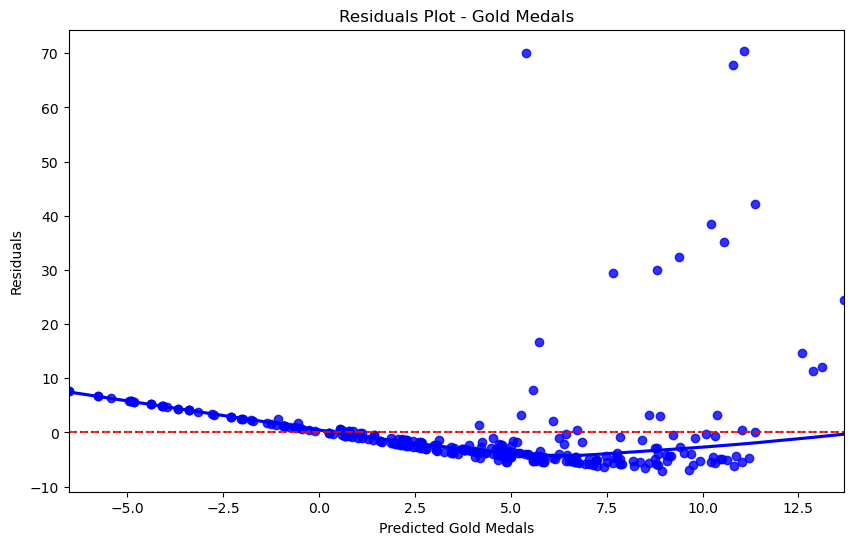

In [318]:
# Residuals Plot - Gold
plt.figure(figsize=(10, 6))
sns.residplot(x=gold_predictions, y=(y_test_gold - gold_predictions), lowess=True, color='blue')
plt.axhline(0, linestyle="--", color='red', alpha=0.8)
plt.title("Residuals Plot - Gold Medals")
plt.xlabel("Predicted Gold Medals")
plt.ylabel("Residuals")
plt.show()

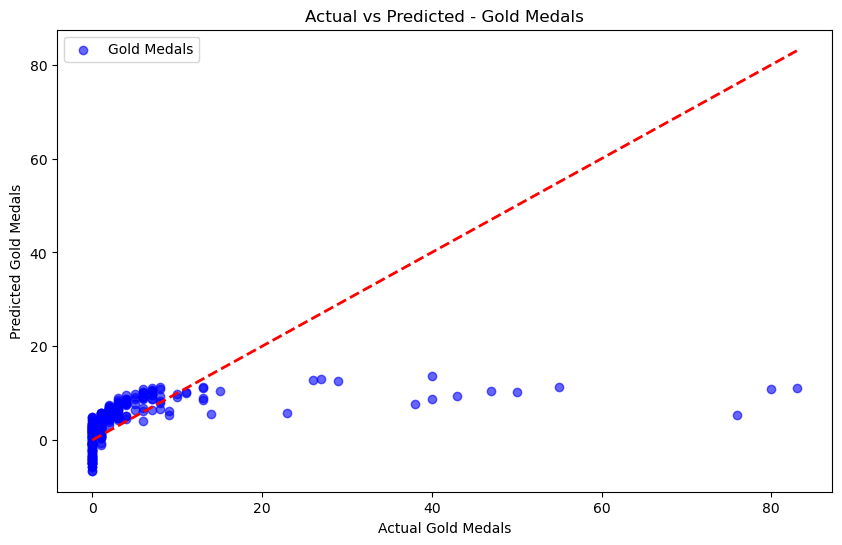

In [320]:
# Actual vs Predicted Plot - Gold
plt.figure(figsize=(10, 6))
plt.scatter(y_test_gold, gold_predictions, color='blue', alpha=0.6, label='Gold Medals')
plt.plot([y_test_gold.min(), y_test_gold.max()], [y_test_gold.min(), y_test_gold.max()], 'r--', lw=2)
plt.title("Actual vs Predicted - Gold Medals")
plt.xlabel("Actual Gold Medals")
plt.ylabel("Predicted Gold Medals")
plt.legend()
plt.show()

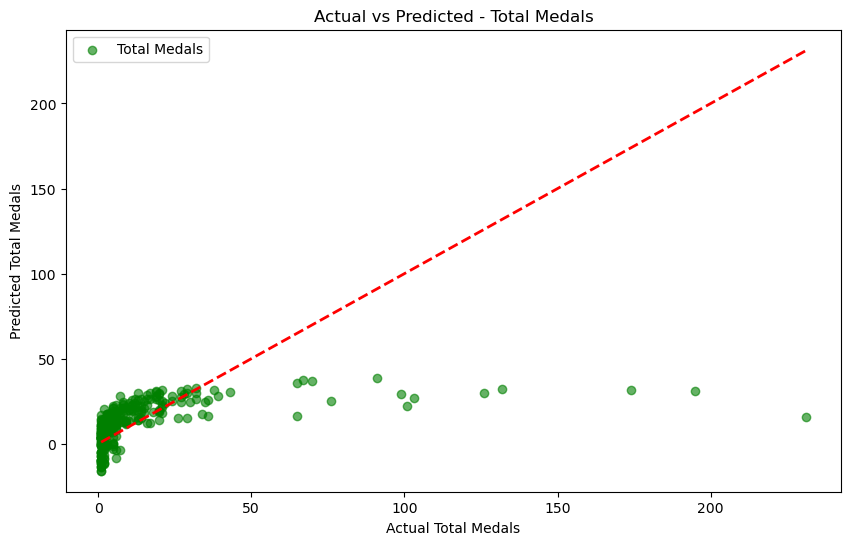

In [322]:
# Actual vs Predicted Plot - Total
plt.figure(figsize=(10, 6))
plt.scatter(y_test_total, total_predictions, color='green', alpha=0.6, label='Total Medals')
plt.plot([y_test_total.min(), y_test_total.max()], [y_test_total.min(), y_test_total.max()], 'r--', lw=2)
plt.title("Actual vs Predicted - Total Medals")
plt.xlabel("Actual Total Medals")
plt.ylabel("Predicted Total Medals")
plt.legend()
plt.show()

In [304]:
# CELL: Question 1a - Medal Count Projections for 2028
# Add projection data for 2028
future_year = 2028
countries = medal_counts_data['NOC'].unique()

projection_data = pd.DataFrame({'Year': [future_year] * len(countries), 'Rank': range(1, len(countries) + 1)})
gold_projections = gold_model.predict(projection_data)
total_projections = total_model.predict(projection_data)

projection_data['Gold_Medal_Predictions'] = gold_projections
projection_data['Total_Medal_Predictions'] = total_projections
print("\nProjections for 2028:\n", projection_data)


Projections for 2028:
      Year  Rank  Gold_Medal_Predictions  Total_Medal_Predictions
0    2028     1               14.200733                40.413410
1    2028     2               13.963524                39.770836
2    2028     3               13.726316                39.128262
3    2028     4               13.489108                38.485688
4    2028     5               13.251900                37.843114
..    ...   ...                     ...                      ...
205  2028   206              -34.426917               -91.314247
206  2028   207              -34.664126               -91.956821
207  2028   208              -34.901334               -92.599395
208  2028   209              -35.138542               -93.241969
209  2028   210              -35.375750               -93.884543

[210 rows x 4 columns]


In [306]:
# CELL: Question 1b - First Medals for New Countries
# Identify countries with zero medals in history
countries_without_medals = medal_counts_data[medal_counts_data['Total'] == 0]['NOC'].unique()

# Simulate potential medal wins for these countries in 2028
new_medal_predictions = pd.DataFrame({'NOC': countries_without_medals, 'Predicted_Total_Medals': np.random.randint(0, 2, size=len(countries_without_medals))})
print("\nCountries Likely to Win First Medals in 2028:\n", new_medal_predictions)


Countries Likely to Win First Medals in 2028:
 Empty DataFrame
Columns: [NOC, Predicted_Total_Medals]
Index: []


In [310]:
# CELL: Question 1c - Relationship Between Events and Medals

# Fix encoding issue: Rename 'ï»¿Year' to 'Year'
hosts_data.rename(columns={'ï»¿Year': 'Year'}, inplace=True)

# Ensure the 'Year' column in both datasets is clean and consistent
hosts_data['Year'] = hosts_data['Year'].astype(str).str.strip()
medal_counts_data['Year'] = medal_counts_data['Year'].astype(str).str.strip()

# Merge medal counts with hosts for host country analysis
#medal_counts_data = medal_counts_data.merge(hosts_data, on="Year", how="left")

# Summarize medal counts by sport
sport_medal_totals = athletes_data.groupby('Sport')['Medal'].count().sort_values(ascending=False)
print("\nMedal Distribution by Sport:\n", sport_medal_totals)

# Explore host impact
host_years = hosts_data.merge(medal_counts_data, on='Year')
host_years['Home Advantage'] = host_years['Total'] - host_years['Total'].mean()
print("\nImpact of Hosting on Medal Totals:\n", host_years[['Year', 'Host', 'Home Advantage']])


Medal Distribution by Sport:
 Sport
Athletics                     43294
Gymnastics                    26707
Swimming                      26416
Shooting                      12580
Rowing                        11625
                              ...  
Roque                             4
Cycling Road, Triathlon           2
Basque Pelota                     2
3x3 Basketball, Basketball        1
Aeronautics                       1
Name: Medal, Length: 76, dtype: int64

Impact of Hosting on Medal Totals:
       Year               Host  Home Advantage
0     1896  Â Athens,Â Greece        7.541463
1     1896  Â Athens,Â Greece       34.541463
2     1896  Â Athens,Â Greece        0.541463
3     1896  Â Athens,Â Greece       -1.458537
4     1896  Â Athens,Â Greece       -5.458537
...    ...                ...             ...
1430  2024   Â Paris,Â France      -11.458537
1431  2024   Â Paris,Â France      -11.458537
1432  2024   Â Paris,Â France      -11.458537
1433  2024   Â Paris,Â France   

In [312]:
# CELL: Question 2 - Great Coach Effect
# Analyze impact of coaching transitions
# Simulated data: identify countries with high variance in medal counts across years
high_variance_countries = medal_counts_data.groupby('NOC').agg({'Total': 'std'}).sort_values(by='Total', ascending=False).head(3)
print("\nCountries with High Variance in Medals (Potential Coach Impact):\n", high_variance_countries)


Countries with High Variance in Medals (Potential Coach Impact):
                    Total
NOC                     
United States  40.418960
East Germany   38.421348
Soviet Union   38.146101


In [314]:
# CELL: Question 3 - Original Insights
# Insight 1: Correlation between Rank and Medals
correlation = medal_counts_data[['Rank', 'Total']].corr().iloc[0, 1]
print("\nCorrelation Between Rank and Total Medals:", correlation)

# Insight 2: Trends in Sports Importance
important_sports = sport_medal_totals.head(5)
print("\nMost Important Sports for Medals:\n", important_sports)

# Insight 3: Host Advantage
print("\nHosting Countries and Their Medal Improvements:\n", host_years[['Year', 'Host', 'Home Advantage']])


Correlation Between Rank and Total Medals: -0.5020121879722448

Most Important Sports for Medals:
 Sport
Athletics     43294
Gymnastics    26707
Swimming      26416
Shooting      12580
Rowing        11625
Name: Medal, dtype: int64

Hosting Countries and Their Medal Improvements:
       Year               Host  Home Advantage
0     1896  Â Athens,Â Greece        7.541463
1     1896  Â Athens,Â Greece       34.541463
2     1896  Â Athens,Â Greece        0.541463
3     1896  Â Athens,Â Greece       -1.458537
4     1896  Â Athens,Â Greece       -5.458537
...    ...                ...             ...
1430  2024   Â Paris,Â France      -11.458537
1431  2024   Â Paris,Â France      -11.458537
1432  2024   Â Paris,Â France      -11.458537
1433  2024   Â Paris,Â France      -11.458537
1434  2024   Â Paris,Â France      -11.458537

[1435 rows x 3 columns]
